<a href="https://colab.research.google.com/github/cnavea/MomentCurvature/blob/main/MomentCurvatureAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Clone only if the folder doesn't exist yet
if not os.path.exists("/content/MomentCurvature"):
    !git clone https://github.com/cnavea/MomentCurvature.git
else:
    print("MomentCurvature repository already exists — skipping clone.")
%cd /content/MomentCurvature
import importlib
import functions
importlib.reload(functions)


MomentCurvature repository already exists — skipping clone.
/content/MomentCurvature


<module 'functions' from '/content/MomentCurvature/functions.py'>

In [40]:
P = -66.0                  # kips target axial
D_column = 18.0            # in
h_col     = 120 + 7/8      # in
section_slices  = 200

# Steel Properties
E_s = 29000.0 #ksi
Fy  = 72.5 #ksi (from testing)
Fu  = 98.1 #ksi (from testing)
eps_h = 0.012
eps_u = 0.12

# Concrete Properties
Fc = 5.0 #ksi

# Define Longitudinal Reinforcement
vertRebar = functions.RebarMaterial(E=E_s, Fy=Fy, Fu=Fu, size=5, eps_u=eps_u, eps_h=eps_h,
                       n_bars=17, r=7.8125, start="left")
# Define Transverse reinforcement
transRebar = functions.RebarMaterial(E=E_s, Fy=Fy, Fu=Fu, size=3, eps_u=eps_u, eps_h=eps_h,
                        spacing=2.75, r=8.3125)

# Define unconfined & confined concrete
unconf = functions.ConcreteMaterial(fc=Fc)
conf   = functions.ConcreteMaterial(fc=Fc, rebar=transRebar)

# Define Column object with materials and specs
col = functions.Column(trans=transRebar, long=vertRebar, unconfined=unconf, confined=conf,
               d=D_column, h=h_col, n_slices=section_slices)

In [41]:
# ----------------------------------------
# 4) Curvature stepping (simple or adaptive)
# ----------------------------------------
phi = 0.0
dphi = 0.00001  # in^-1  (start elastic; you can adapt this later)
phi_max = 0.009  # stop criterion example

phis = []
eps0s = []
Ftotals = []
Ms = []
convergeTimeExpand = []
convergeNewton = []
convergeBi = []

prevEps0 = 0.0
while phi <= phi_max:
    # Solve eps0 for current phi so that the total axial = P
    eps0,a,b,c = functions.find_eps0(col, phi, P, prevEps0)
    prevEps0 = eps0

    F_conc, F_steel, F_tot = col.axial_forces(eps0, phi)

    # Simple bending moment about section center using forces per slice/bar:
    #   M = sum(F_i * x_i) for concrete + sum(F_bar * x_b) for steel
    r = col.outerR
    M_conc = np.sum(F_conc * -col.xi)   #   M = Σ ([F]_i * [x]_i)

    M_steel = 0.0
    # Each steel force in F_steel_vec acts at its xb
    M_steel = np.sum(F_steel * -col.longReinf.xb)

    M = M_conc + M_steel  # kip-in

    # store
    convergeTimeExpand.append(a)
    convergeNewton.append(b)
    convergeBi.append(c)
    phis.append(phi)
    eps0s.append(eps0)
    Ftotals.append(F_tot)
    Ms.append(M)

    if phi == 0.001:
        dphi = 0.0001
    # Advance curvature (could add adaptive control here)
    phi += dphi



In [42]:
L = []
F = max(Ms) / h_col #kips lateral load
L = h_col - Ms / F
print(F)
print(max(Ms))
print(max(L))
print(conf.eps_u)

30.519910366181644
3689.0941655122065
120.875
0.028840143884759615


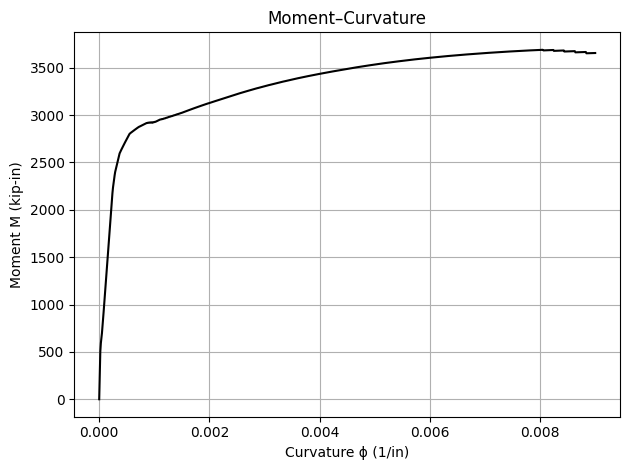

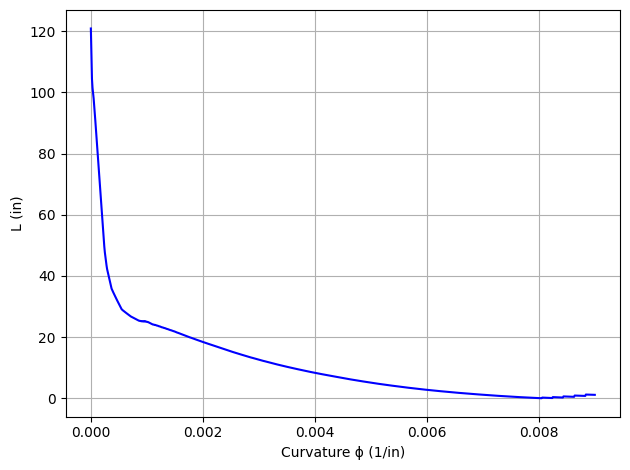

In [43]:
# -----------------------------
# 5) Plot quick checks (optional)
# -----------------------------
plt.figure()
plt.plot(phis, Ms, '-k')
plt.xlabel('Curvature ϕ (1/in)')
plt.ylabel('Moment M (kip-in)')
plt.title('Moment–Curvature')
plt.grid(True)
plt.tight_layout()

plt.figure()
plt.plot(phis, L, '-b')
plt.xlabel('Curvature ϕ (1/in)')
plt.ylabel('L (in)')
plt.grid(True)
plt.tight_layout()

plt.show()


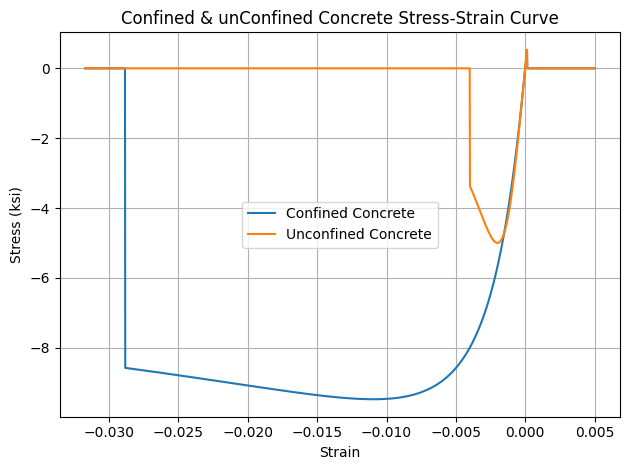

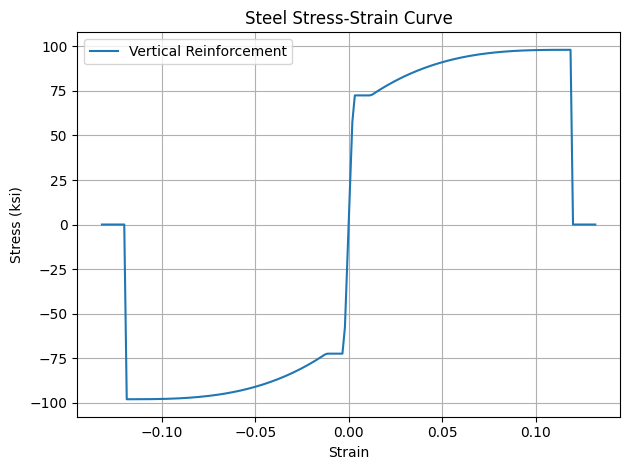

In [44]:
#concrete Stress Strain
eps_cr_conf  = conf.fr / conf.Ec

X = np.linspace(-(conf.eps_u + conf.eps_u*0.10),0.005,2000)
Y1 = [conf.stress(e) for e in X]
Y2 = [unconf.stress(e) for e in X]

plt.figure()
plt.plot(X,Y1,label ="Confined Concrete")
plt.plot(X,Y2,label ="Unconfined Concrete")
plt.xlabel('Strain')
plt.ylabel('Stress (ksi)')
plt.title('Confined & unConfined Concrete Stress-Strain Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()

#steel Stress Strain
X = np.linspace(-(vertRebar.eps_u + vertRebar.eps_u*0.10),vertRebar.eps_u + vertRebar.eps_u*0.10,200)
Y3 = [vertRebar.stress(e) for e in X]

plt.figure()
plt.plot(X,Y3,label ="Vertical Reinforcement")
plt.xlabel('Strain')
plt.ylabel('Stress (ksi)')
plt.title('Steel Stress-Strain Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [45]:
import pandas as pd

L = L[::-1]
phis = phis[::-1]

# Create a DataFrame
df = pd.DataFrame({
    "L (in)": L,
    "ϕ (rad/in)": phis
})
# Export to Excel
df.to_excel("moment_curvature.xlsx", index=False)
from google.colab import files
files.download("moment_curvature.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>